# Largest Contour - Minimum Enclosing Circle

This notebook displays a masking process which finds the largest contour of the image and draws the minimum enclosing circle around the contour.

As DCA's are circular in nature, a bounding circle has been used to resemble the lens shape. By drawing a new circle over the top of the largest contour, any overhanging nevi or alternative artifacts will not affect the image masking process.

---------
## Standard Imports

In [1]:
# append custom system path for custom modules folder in directory if not already
import sys
if  '../../Modules' not in sys.path:
    sys.path.insert(0, '../../Modules')

import pandas as pd
import numpy as np
from PIL import Image
import os, os.path
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import Bunch
import cv2 as cv
import image_modifications as im # custom image modification module
import isic_data as isic

-------------
## Load dataset into memory

In [2]:
X = isic.get_data(type = 'none')

lesions_train = X[0]
lesions_test = X[1]

-----
## Read annotations

Use the annotation .csv files in Data/Annotations to ensure images that have DCA's are selected for masking

In [3]:
# use annotations to get DCA images
t_mel_csv = pd.read_csv(r"../../Data/Annotations/train_mel.csv")
t_oth_csv = pd.read_csv(r"../../Data/Annotations/train_oth.csv")
v_mel_csv = pd.read_csv(r"../../Data/Annotations/val_mel.csv")
v_oth_csv = pd.read_csv(r"../../Data/Annotations/val_oth.csv")

# drop cols not needed
t_mel_csv = t_mel_csv.drop(['Other', 'Clinical_Markings', 'Air_Pockets', 'Measurement_Device', 'Hair', 'Borders'], axis = 1)
t_oth_csv = t_oth_csv.drop(['Other', 'Clinical_Markings', 'Air_Pockets', 'Measurement_Device', 'Hair', 'Borders'], axis = 1)
v_mel_csv = v_mel_csv.drop(['Other', 'Clinical_Markings', 'Air_Pockets', 'Measurement_Device', 'Hair', 'Borders'], axis = 1)
v_oth_csv = v_oth_csv.drop(['Other', 'Clinical_Markings', 'Air_Pockets', 'Measurement_Device', 'Hair', 'Borders'], axis = 1)


# drop rows that arent DCA's - DCA's are recorded as type 3, inverted DCA's are recorded as type 5
ind = t_mel_csv[(t_mel_csv['Border_Type'] != 3) & (t_mel_csv['Border_Type'] != 5)].index
t_mel_csv.drop(ind, inplace = True)

ind = t_oth_csv[(t_oth_csv['Border_Type'] != 3) & (t_oth_csv['Border_Type'] != 5)].index
t_oth_csv.drop(ind, inplace = True)

ind = v_mel_csv[(v_mel_csv['Border_Type'] != 3) & (v_mel_csv['Border_Type'] != 5)].index
v_mel_csv.drop(ind, inplace = True)

ind = v_oth_csv[(v_oth_csv['Border_Type'] != 3) & (v_oth_csv['Border_Type'] != 5)].index
v_oth_csv.drop(ind, inplace = True)

t_mel_csv = t_mel_csv.drop(['Border_Type'], axis = 1)
t_oth_csv = t_oth_csv.drop(['Border_Type'], axis = 1)
v_mel_csv = v_mel_csv.drop(['Border_Type'], axis = 1)
v_oth_csv = v_oth_csv.drop(['Border_Type'], axis = 1)


# append trains and vals together
mel_csv = t_mel_csv.append(t_oth_csv, ignore_index = True)
val_csv = v_mel_csv.append(v_oth_csv, ignore_index = True)

# append all together into one
annotated_borders = mel_csv.append(val_csv, ignore_index = True)

# transpose
mel_csv = mel_csv.transpose()
val_csv = val_csv.transpose()
annotated_borders = annotated_borders.transpose()

# convert from df to ndarrays for comparison against dataset filename ndarray
mel_csv.to_numpy()
val_csv.to_numpy()
annotated_borders.to_numpy()

array([['ISIC2017_0000030_mel.jpg', 'ISIC2017_0000031_mel.jpg',
        'ISIC2017_0000077_mel.jpg', ..., 'ISIC2020_8592827_oth.jpg',
        'ISIC2020_9169000_oth.jpg', 'ISIC2020_9828463_oth.jpg']],
      dtype=object)

In [ ]:
annotated_borders

-----
## Select image(s) to create mask on

Select an image to experiment with. To select a different image, modify the image_value variable. This variable references the array index.

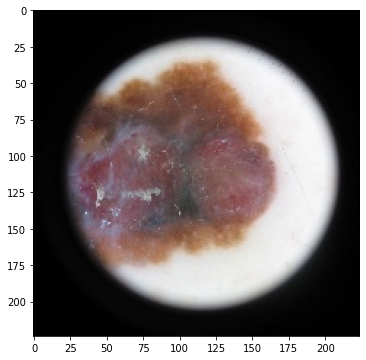

In [4]:
# select image from training dataset
image_value = 999 #105 is a good pertrusion example
example_image = np.copy(lesions_train.images[lesions_train.filenames == mel_csv[image_value]['Image_Name']])

# convert to grayscale
example_image_gray = cv.cvtColor(example_image[0], cv.COLOR_RGB2GRAY)

# display the image
plt.figure(figsize = (6,6))
plt.imshow(example_image[0]);

-------
## Find all of the image contours

Retrive all contours in the image using the defined threshold. Display them to see what contours have been located.

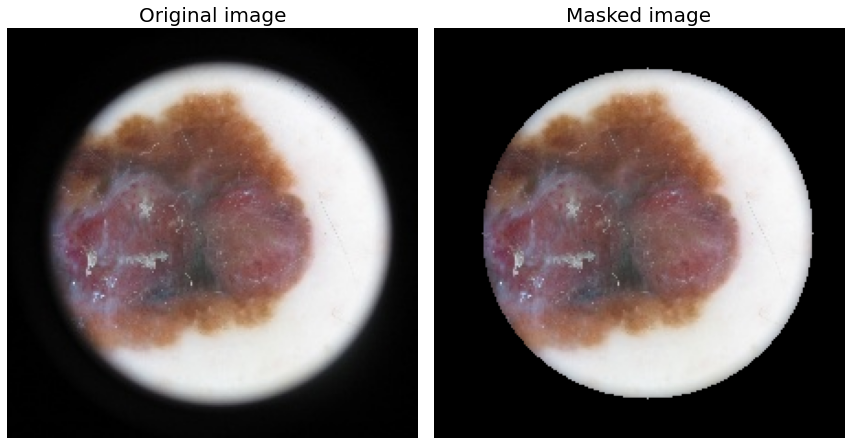

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (15,15));
#axes[0].imshow(mask, cmap = 'gray');
#axes[0].set_title("Largest Contour Mask", fontsize = 20)

#axes[1].imshow(this_contour, cmap = 'gray');
#axes[1].set_title("Minimum Enclosed Circle", fontsize = 20)

axes[0].imshow(example_image[0]);
axes[0].set_title("Original image", fontsize = 20)

axes[1].imshow(output);
axes[1].set_title("Masked image", fontsize = 20)




for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
plt.subplots_adjust(wspace=0.04)

fig.savefig(r'D:\OneDrive - MMU\Year 3\MMU Dissertation\Diss Figures\BAE_Masking1')

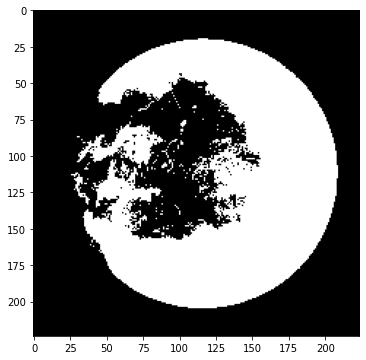

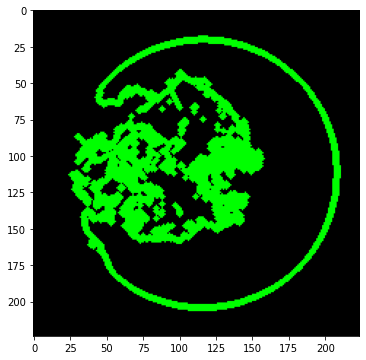

In [5]:
# set a threshold value and retrieve the binary threshold for the grayscale image
image_thresh = 100
ret,thresh_img = cv.threshold(example_image_gray, image_thresh, 255, cv.THRESH_BINARY)

# display the thresholded image
plt.figure(figsize = (6,6))
plt.imshow(thresh_img, cmap = 'gray');

# find all of the contours in the threshold image
contours, hierarchy = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img_contours = np.zeros(example_image[0].shape)

# show all of the found contours
plt.figure(figsize = (6,6))
plt.imshow((cv.drawContours(img_contours, contours, -1, (0,255,0), 3)).astype(np.uint8));

-----
## Find the largest contour

Use the list of contours found in the previous step to find the largest contour. On DCA images this should follow the shape of the DCA (unless there is an obtrusion).

As can be seen in some of the cases, there is still some noise in the centre of the mask.

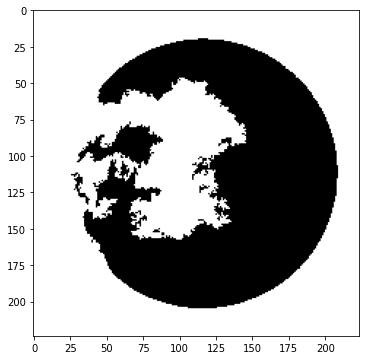

In [10]:
# i do this again?
#contours,hierarchy = cv.findContours(thresh_img,2,1)
#cnt = contours
contoursB = []
big_contour = []
max = 0
for i in contours:
    area = cv.contourArea(i) #--- find the contour having biggest area ---
    if(area > max):
        max = area
        big_contour = i 
        contoursB.append(i)
        
#_, example_image_gray = cv.threshold(example_image_gray, 128, 255, cv.THRESH_BINARY)

# find contours
#cnts, _ = cv.findContours(example_image_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# generate mask
mask = np.ones(example_image_gray.shape)
mask = cv.drawContours(mask, contoursB, -1, 0, cv.FILLED)

# display the mask using only the largest contour
plt.figure(figsize = (6,6))
plt.imshow(mask, cmap = 'gray');

-------
## Draw new outer ring

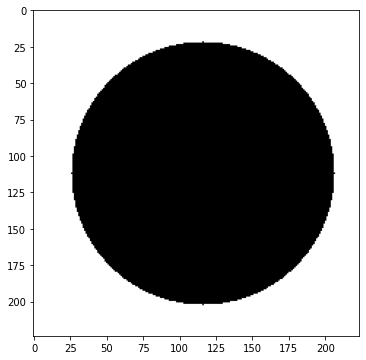

In [19]:
# find the minimum enclosing circle centre coordinates and radius
(x,y), radius = cv.minEnclosingCircle(big_contour)
center = (int(x), int(y))

# negate from the radius to account for the 'transition zone' into the DCA
radius = int(radius) - 2

# create the new masking circle using the centre point and the new radius
this_contour = cv.circle(np.ones(example_image_gray.shape),center,radius,(0,255,0),-1)

# display the new mask
plt.figure(figsize = (6,6))
plt.imshow(this_contour, cmap = 'gray');

-----
## Transpose mask into image

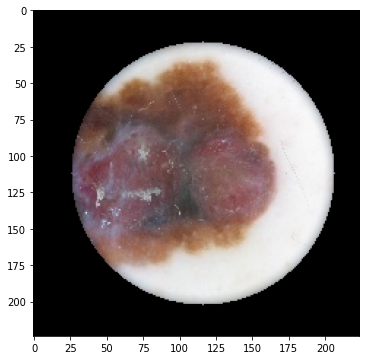

In [20]:
# copy the original image into an output variable and apply the mask
output = example_image[0].copy()
output[this_contour.astype(np.bool)] = 0

# display the masked image
plt.figure(figsize = (6,6))
plt.imshow(output);